Data Source - https://www.kaggle.com/mlg-ulb/creditcardfraud
After SMOTE the data is now balanced, and now we used the ensembles and Deep Auto Encoders to do training and see the results on testing.

In [1]:
'''So now the idea is to train it correctly and set/adjust the threshold so that confusion matrix is 
set in such way that accuracy is high. Now accuracy is the correct measure to consider as we have exactly 50-50% balanced dataset
for each class for training so,
'''
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.
C:\Users\d071556\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Reading the datafiles in memory.

In [3]:
df = pd.read_csv("./ccfd_train.csv") #This needs to be adjusted.
test_df = pd.read_csv('./ccfd_test.csv')
dataDae = pd.read_csv('./ccfd_train.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V9,V10,V14,V16,V17,V18,V19,V21,Amount,Class
0,0.263980,0.975480,0.768060,0.831231,0.316356,0.766998,0.264401,0.480854,0.492552,0.600237,0.458462,0.764043,0.660305,0.539059,0.556330,0.003900,1
1,0.996643,0.990015,0.761044,0.827419,0.272936,0.762375,0.261666,0.498740,0.509883,0.645043,0.466434,0.711363,0.663609,0.523826,0.565077,0.003118,0
2,0.801443,0.934175,0.775426,0.836357,0.182667,0.771340,0.255168,0.478236,0.512373,0.651439,0.464644,0.695678,0.634542,0.499532,0.558385,0.000077,0
3,0.445359,0.969883,0.781349,0.815875,0.342284,0.774352,0.254664,0.456329,0.463648,0.475218,0.473543,0.848716,0.739162,0.509612,0.555836,0.000039,1
4,0.463427,0.955610,0.778116,0.869931,0.388904,0.759693,0.278908,0.423913,0.510500,0.658230,0.450287,0.744509,0.673921,0.585011,0.542966,0.000996,1


In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V9,V10,V14,V16,V17,V18,V19,V21,Amount,Class
0,0.263980,0.975480,0.768060,0.831231,0.316356,0.766998,0.264401,0.480854,0.492552,0.600237,0.458462,0.764043,0.660305,0.539059,0.556330,0.003900,1
1,0.996643,0.990015,0.761044,0.827419,0.272936,0.762375,0.261666,0.498740,0.509883,0.645043,0.466434,0.711363,0.663609,0.523826,0.565077,0.003118,0
2,0.801443,0.934175,0.775426,0.836357,0.182667,0.771340,0.255168,0.478236,0.512373,0.651439,0.464644,0.695678,0.634542,0.499532,0.558385,0.000077,0
3,0.445359,0.969883,0.781349,0.815875,0.342284,0.774352,0.254664,0.456329,0.463648,0.475218,0.473543,0.848716,0.739162,0.509612,0.555836,0.000039,1
4,0.463427,0.955610,0.778116,0.869931,0.388904,0.759693,0.278908,0.423913,0.510500,0.658230,0.450287,0.744509,0.673921,0.585011,0.542966,0.000996,1


Visualize the data, now we can see that the data is balanced perfectly.

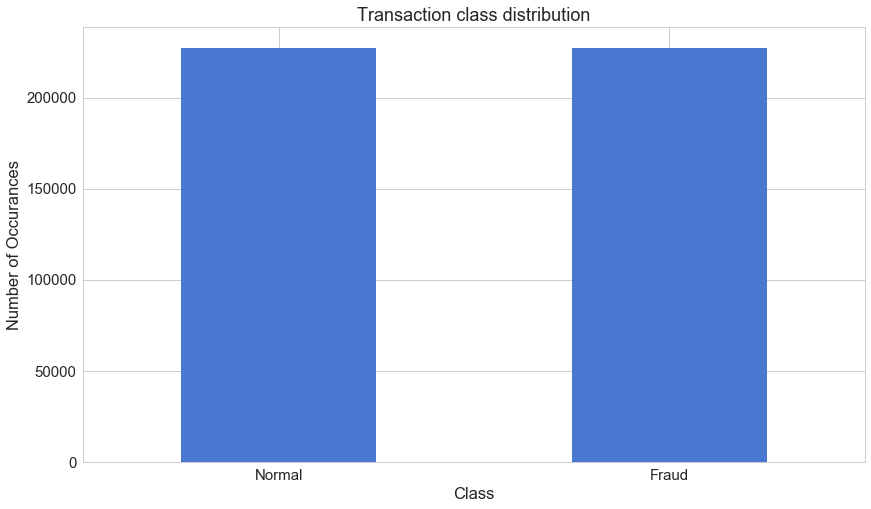

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Number of Occurances")

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(227446, 17)

In [7]:
normal.shape

(227446, 17)

In [9]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V9,V10,V14,V16,V17,V18,V19,V21,Amount,Class
0,0.263980,0.975480,0.768060,0.831231,0.316356,0.766998,0.264401,0.480854,0.492552,0.600237,0.458462,0.764043,0.660305,0.539059,0.556330,0.003900,1
1,0.996643,0.990015,0.761044,0.827419,0.272936,0.762375,0.261666,0.498740,0.509883,0.645043,0.466434,0.711363,0.663609,0.523826,0.565077,0.003118,0
2,0.801443,0.934175,0.775426,0.836357,0.182667,0.771340,0.255168,0.478236,0.512373,0.651439,0.464644,0.695678,0.634542,0.499532,0.558385,0.000077,0
3,0.445359,0.969883,0.781349,0.815875,0.342284,0.774352,0.254664,0.456329,0.463648,0.475218,0.473543,0.848716,0.739162,0.509612,0.555836,0.000039,1
4,0.463427,0.955610,0.778116,0.869931,0.388904,0.759693,0.278908,0.423913,0.510500,0.658230,0.450287,0.744509,0.673921,0.585011,0.542966,0.000996,1


In [10]:
y_train = df['Class']
x_train = df.drop('Class',axis=1)
y_val = test_df['Class']
x_val = test_df.drop('Class',axis=1)

In [12]:
data = df

In [13]:
print(len(df))

454892


Training the data with RandomForest. 

In [14]:
clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=200,#None,#
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)
clf_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=200,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [15]:
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
output = clf_rf.predict(x_val)
conf_matrix = confusion_matrix(y_val, output)
print(conf_matrix)

[[56369   500]
 [   11    82]]


Accuracy with Random forest.

In [16]:
print('Overall accuracy = ', (conf_matrix[0][0] + conf_matrix[1][1])/(conf_matrix[0][0] + conf_matrix[1][1] 
                                                                    + conf_matrix[0][1] + conf_matrix[1][0]))

Overall accuracy =  0.991029107124


Creating Classification Report.

In [17]:
target_names = ['class 0', 'class 1']
print(classification_report(y_val, output, target_names=target_names))

             precision    recall  f1-score   support

    class 0       1.00      0.99      1.00     56869
    class 1       0.14      0.88      0.24        93

avg / total       1.00      0.99      0.99     56962



Training the data with Gradient Boosting Classifier.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_features = 'sqrt',
                                     n_estimators=5,
                                     learning_rate = 0.1,
                                     max_depth = 6,
                                     subsample = 0.5).fit(x_train, y_train)

"clf = GradientBoostingClassifier(loss='deviance', \n                                 n_estimators=10,\n                                 learning_rate=0.5,\n                                 max_depth = 6, \n                                 random_state=0,\n                                 max_features = 'sqrt',\n                                 subsample=0.5).fit(x_train, y_train)"

Calculating Accuracy.

In [20]:
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
output = clf.predict(x_val)
conf_matrix = confusion_matrix(y_val, output)
print(conf_matrix)

[[56297   572]
 [    9    84]]


In [21]:
print('Overall accuracy = ', (conf_matrix[0][0] + conf_matrix[1][1])/(conf_matrix[0][0] + conf_matrix[1][1] 
                                                                    + conf_matrix[0][1] + conf_matrix[1][0]))

Overall accuracy =  0.989800217689


Creating Classification Report.

In [22]:
target_names = ['class 0', 'class 1']
print(classification_report(y_val, output, target_names=target_names))

             precision    recall  f1-score   support

    class 0       1.00      0.99      0.99     56869
    class 1       0.13      0.90      0.22        93

avg / total       1.00      0.99      0.99     56962



In [24]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf1.fit(x_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
output = clf1.predict(x_val)
conf_matrix = confusion_matrix(y_val, output)
print(conf_matrix)

[[55630  1239]
 [    7    86]]


In [26]:
print('Overall accuracy = ', (conf_matrix[0][0] + conf_matrix[1][1])/(conf_matrix[0][0] + conf_matrix[1][1] 
                                                                    + conf_matrix[0][1] + conf_matrix[1][0]))

Overall accuracy =  0.978125768056


In [27]:
target_names = ['class 0', 'class 1']
print(classification_report(y_val, output, target_names=target_names))

             precision    recall  f1-score   support

    class 0       1.00      0.98      0.99     56869
    class 1       0.06      0.92      0.12        93

avg / total       1.00      0.98      0.99     56962



In [29]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(class_weight=None, criterion='gini', 
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, max_depth=6,min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=120,
            splitter='best')            #Keep max depth < 15
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=120,
            splitter='best')

In [30]:
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
output = dt_clf.predict(x_val)
conf_matrix = confusion_matrix(y_val, output)
print(conf_matrix)

[[54683  2186]
 [    8    85]]


In [31]:
dt_clf_acc = (conf_matrix[0][0] + conf_matrix[1][1])/(conf_matrix[0][0] + conf_matrix[1][1] 
                                                                    + conf_matrix[0][1] + conf_matrix[1][0])
print('Overall accuracy = ', dt_clf_acc)
print('Classifier name = ', dt_clf.__class__.__name__,' Accuracy = ' , dt_clf_acc)

Overall accuracy =  0.961483093992
Classifier name =  DecisionTreeClassifier  Accuracy =  0.961483093992


In [33]:
from sklearn.svm import LinearSVC
linsvc_clf = LinearSVC(loss='squared_hinge', dual=True, tol=0.1, C=1.0, multi_class='ovr', fit_intercept=True,penalty='l2', 
                                               intercept_scaling=1, random_state=None, max_iter=200)
linsvc_clf.fit(x_train, y_train) # doctest : +ELLIPSIS
#keep max iters - 50 - 11% , 70 - 8% , 200 - 89%

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=200,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.1,
     verbose=0)

In [34]:
output = linsvc_clf.predict(x_val)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, output)    
print(cm)

[[55711  1158]
 [    8    85]]


In [35]:
linsvc_clf_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
print("Accuracy = " , linsvc_clf_acc)
print('Classifier name = ', linsvc_clf.__class__.__name__,' Accuracy = ' , linsvc_clf_acc)

Accuracy =  0.979530213125
Classifier name =  LinearSVC  Accuracy =  0.979530213125


In [36]:
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
target_names = ['class 0', 'class 1']
print(classification_report(y_val, output, target_names=target_names))

             precision    recall  f1-score   support

    class 0       1.00      0.98      0.99     56869
    class 1       0.07      0.91      0.13        93

avg / total       1.00      0.98      0.99     56962



In [38]:
from sklearn.ensemble import AdaBoostClassifier
clf5=AdaBoostClassifier(n_estimators=10,random_state=42).fit(x_train, y_train)


In [39]:
output = clf5.predict(x_val)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, output)    
print(cm) 

[[54747  2122]
 [    8    85]]


In [40]:
print("Accuracy = " , (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0]))

Accuracy =  0.962606650047


In [41]:
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
target_names = ['class 0', 'class 1']
print(classification_report(y_val, output, target_names=target_names))

             precision    recall  f1-score   support

    class 0       1.00      0.96      0.98     56869
    class 1       0.04      0.91      0.07        93

avg / total       1.00      0.96      0.98     56962



In [43]:
print(len(data))

454892


In [46]:
data_nn = data
train_y = data_nn.iloc[:,-1]
train_x = []
del data_nn['Class']

for row in data_nn.iterrows():
    index, data = row
    train_x.append(data.tolist())

test_y = test_df.iloc[:,-1]
test_x = []
del test_df['Class']

for row in test_df.iterrows():
    index, da = row
    test_x.append(da.tolist())

Creating an architechture for Neural network to train on the data.

In [47]:
# hidden layers and their nodes
input_nodes = 18

n_nodes_hl1 = 100
n_nodes_hl2 = 100
n_nodes_hl3 = 100


# classes in our output
n_classes = 2

# iterations and ba0tch-size
hm_epochs = 10
batch_size = 1024

x = tf.placeholder('float32')
y = tf.placeholder('int64')

#x=tf.FixedLenFeature(shape=[3], dtype=tf.float32)
#y=tf.FixedLenFeature(shape=[2], dtype=tf.int64)

# random weights and bias for our layers
hidden_1_layer = {'f_fum':n_nodes_hl1, #tf.random_normal([len(train_x[0])
                  'weight':tf.Variable(tf.random_normal([len(train_x[0]) , n_nodes_hl1]), name='HL1'),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl1]))}

hidden_2_layer = {'f_fum':n_nodes_hl2,
                  'weight':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2], name='HL2')),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl2]))}

hidden_3_layer = {'f_fum':n_nodes_hl3,
                  'weight' : tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_hl3], name='HL3')),
                  'bias' : tf.Variable(tf.random_normal([n_nodes_hl3]))}

output_layer = {'f_fum':n_classes,
                'weight':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes]), name='OL'),
                'bias':tf.Variable(tf.random_normal([n_classes]))}

print("Network outline created !!! with 3 hidden layers with ",n_nodes_hl1, " neurons each !!!")

Network outline created !!! with 3 hidden layers with  100  neurons each !!!


In [48]:
# hidden layer 1: (data * W) + b
l1 = tf.nn.softmax(tf.matmul(x,hidden_1_layer['weight']) +  hidden_1_layer['bias'])
l1=tf.nn.relu(l1)

# hidden layer 2: (hidden_layer_1 * W) + b
l2 = tf.nn.softmax(tf.matmul(l1,hidden_2_layer['weight']) +  hidden_2_layer['bias'])
l2=tf.nn.relu(l2)

# hidden layer 3: (hidden_layer_2 * W) + b
l3 = tf.nn.softmax(tf.matmul(l2,hidden_3_layer['weight']) +  hidden_3_layer['bias'])
l3=tf.nn.relu(l3)

output = tf.nn.softmax(tf.matmul(l3,output_layer['weight']) +  output_layer['bias'])
print("Activation functions started !!!")

Activation functions started !!!


Training the data using tensorflow based neural network.

In [49]:
prediction = output
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, labels=(y)))
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=(y)))

optimizer = tf.train.AdamOptimizer().minimize(cost)

epoch_list = []
cost_list = []
    # Tensorflow session
with tf.Session() as sess:
    # initialize our variables
    init_op = tf.global_variables_initializer() 
    sess.run(init_op)
    # loop through specified number of iterations
    for epoch in range(hm_epochs):
        epoch_loss = 0
        i=0
        # handle batch sized chunks of training data
        while i < len(train_x):
            start = i
            end = i+batch_size
            batch_x = np.array(train_x[start:end])            #(train_x[start:end])
            batch_y = np.array(train_y[start:end])            #(train_y[start:end])
            opti, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
            epoch_loss += c
            i+=batch_size
            last_cost = c
        #print cost updates 
        cost_list.append(last_cost)
        epoch_list.append(epoch)
        if (epoch% (hm_epochs/5)) == 0:
            print('Epoch', epoch, 'completed out of',hm_epochs,'cost:', last_cost)
    correct = tf.equal(tf.argmax(prediction, 1), (y))
    saver = tf.train.Saver(tf.global_variables())
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    print('Accuracy - ' , accuracy)
    save_path = saver.save(sess, "./model.ckpt")
    print("Model saved in file: %s" % save_path)
    print("saved")

Epoch 0 completed out of 10 cost: 0.49191
Epoch 2 completed out of 10 cost: 0.365005
Epoch 4 completed out of 10 cost: 0.355767
Epoch 6 completed out of 10 cost: 0.352887
Epoch 8 completed out of 10 cost: 0.351749
Accuracy -  Tensor("Mean_1:0", dtype=float32)
Model saved in file: ./model.ckpt
saved


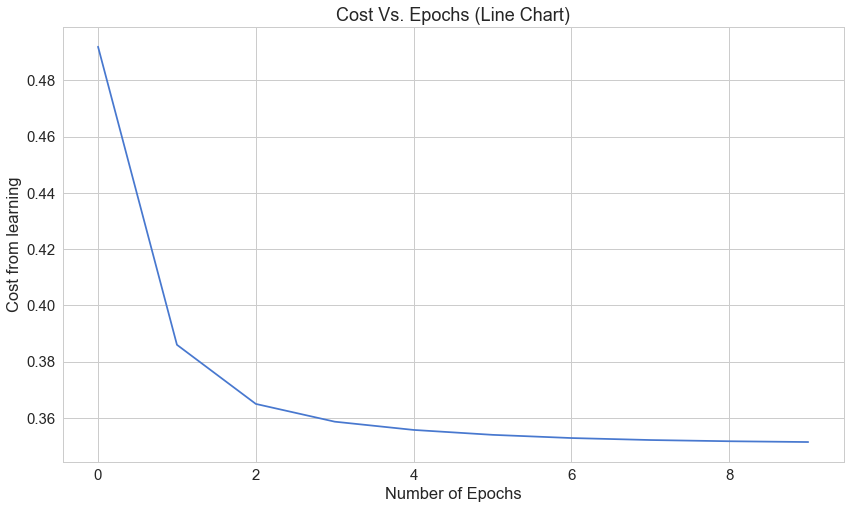

In [50]:
from pylab import *
t = epoch_list
s = cost_list
plot(t,s)
xlabel('Number of Epochs')
ylabel('Cost from learning')
title('Cost Vs. Epochs (Line Chart)')
grid(True)
plt.savefig('loss.png')
show()

Reading the model back in memory.

In [51]:
with tf.Session() as sess:
    prediction = output
    saver = tf.train.Saver(tf.global_variables())
    # Restore variables from disk.
    saver.restore(sess, "./model.ckpt")
    correct = tf.equal(tf.argmax(prediction, 1), (y))
    print("Model restored.")
    # Check the values of the variables
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    print('Accuracy:',accuracy.eval({x:test_x, y:test_y}))
    output_pred= sess.run(tf.argmax(prediction,1),feed_dict={x: test_x})
    print('Output is' , output_pred)
    
print('The confusion matrix is = ')

cm = confusion_matrix(test_y, output_pred)    
print(cm)  

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
Accuracy: 0.984112
Output is [0 0 0 ..., 0 0 0]
The confusion matrix is = 
[[55973   896]
 [    9    84]]


In [68]:
acc_nn = (cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
print('Overall accuracy = ', acc_nn)

Overall accuracy =  0.984112215161


Starting the data preparation for training with Deep Auto Encoder.
Here we separate the normal data and fraud data and train the DAE on normal data forcing it to have lower error for Normal data and then when it sees the fraud data the error for recreation is high and then we can say this particular transaction is fraud because the error is high.

In [52]:
dataDae.head()

,Time,V1,V2,V3,V4,V5,V6,V9,V10,V14,V16,V17,V18,V19,V21,Amount,Class
0,0.263980,0.975480,0.768060,0.831231,0.316356,0.766998,0.264401,0.480854,0.492552,0.600237,0.458462,0.764043,0.660305,0.539059,0.556330,0.003900,1
1,0.996643,0.990015,0.761044,0.827419,0.272936,0.762375,0.261666,0.498740,0.509883,0.645043,0.466434,0.711363,0.663609,0.523826,0.565077,0.003118,0
2,0.801443,0.934175,0.775426,0.836357,0.182667,0.771340,0.255168,0.478236,0.512373,0.651439,0.464644,0.695678,0.634542,0.499532,0.558385,0.000077,0
3,0.445359,0.969883,0.781349,0.815875,0.342284,0.774352,0.254664,0.456329,0.463648,0.475218,0.473543,0.848716,0.739162,0.509612,0.555836,0.000039,1
4,0.463427,0.955610,0.778116,0.869931,0.388904,0.759693,0.278908,0.423913,0.510500,0.658230,0.450287,0.744509,0.673921,0.585011,0.542966,0.000996,1


In [53]:
#X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = dataDae
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values
X_train.shape

(227446, 16)

Creating a deep auto encoder structure with variations in the activations to throw in some resistence for learning. 

In [54]:
input_dim = X_train.shape[1]
encoding_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
hl1 = Dense(int(encoding_dim*20), activation="tanh")(encoder)
hl2 = Dense(int(encoding_dim*20), activation="relu")(hl1)
hl3 = Dense(int(encoding_dim*20), activation="tanh")(hl2)
decoder = Dense(int(encoding_dim*20), activation='relu')(hl3)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Training the DAE for 20 epochs with a batch size of 1024 and calculating the error as a mean squared error and using the optimizer as an Adam Optimizer.

In [55]:
nb_epoch = 20
batch_size = 1024
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir="./logs",
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_val, x_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227446 samples, validate on 56962 samples
Epoch 1/20
227446/227446 [==============================] - 18s 79us/step - loss: 0.0804 - acc: 0.9247 - val_loss: 0.0046 - val_acc: 0.9518
Epoch 2/20
227446/227446 [==============================] - 17s 75us/step - loss: 0.0044 - acc: 0.9513 - val_loss: 0.0047 - val_acc: 0.9523
Epoch 3/20
227446/227446 [==============================] - 18s 78us/step - loss: 0.0042 - acc: 0.9548 - val_loss: 0.0042 - val_acc: 0.9548
Epoch 4/20
227446/227446 [==============================] - 18s 78us/step - loss: 0.0042 - acc: 0.9556 - val_loss: 0.0045 - val_acc: 0.9545
Epoch 5/20
227446/227446 [==============================] - 16s 72us/step - loss: 0.0041 - acc: 0.9556 - val_loss: 0.0041 - val_acc: 0.9549
Epoch 6/20
227446/227446 [==============================] - 16s 70us/step - loss: 0.0040 - acc: 0.9557 - val_loss: 0.0043 - val_acc: 0.9550
Epoch 7/20
227446/227446 [==============================] - 16s 70us/step - loss: 0.0040 - acc: 0.9555 - val_

In [56]:
autoencoder = load_model('model.h5')

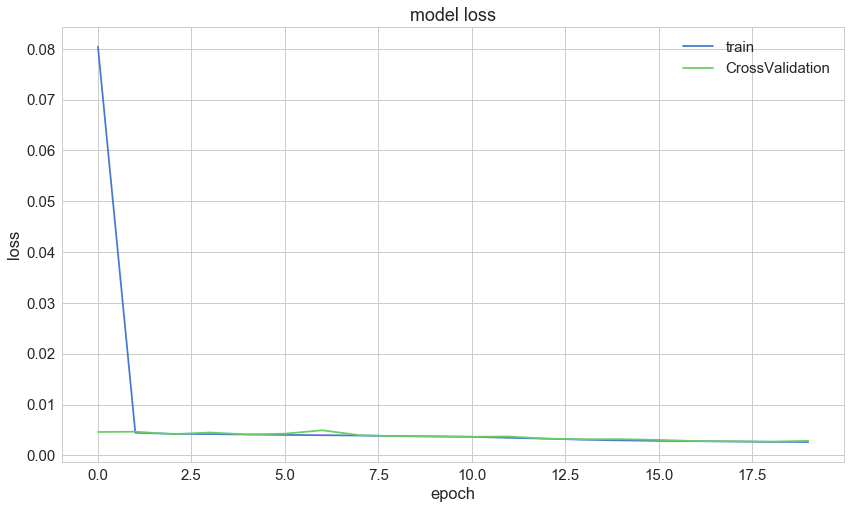

In [57]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'CrossValidation'], loc='upper right');

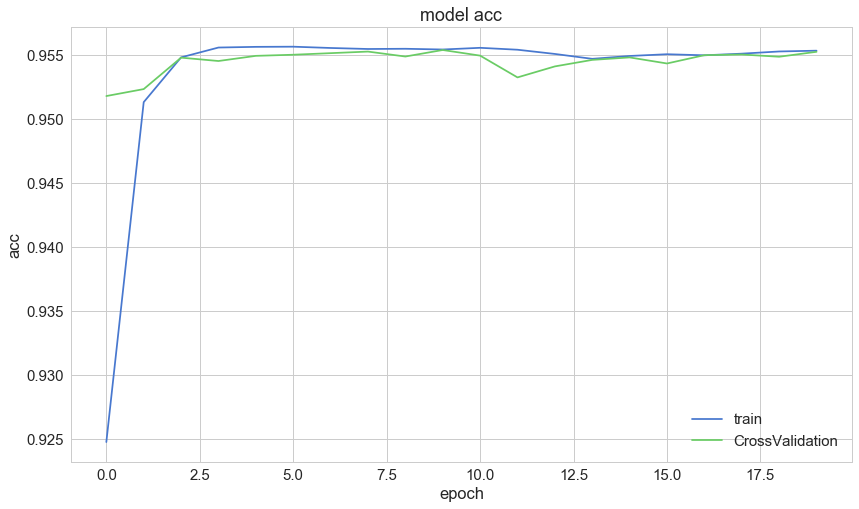

In [58]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'CrossValidation'], loc='lower right');

In [59]:
predictions = autoencoder.predict(x_val)

mse = np.mean(np.power(x_val - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_val})
error_df.head()

,reconstruction_error,true_class
0,0.002110,0
1,0.000706,0
2,0.007250,0
3,0.000198,0
4,0.000923,0


In [60]:
from sklearn.metrics import (confusion_matrix, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [61]:
threshold = 0.02
groups = error_df.groupby('true_class')
groups.head()

,reconstruction_error,true_class
0,0.002110,0
1,0.000706,0
2,0.007250,0
3,0.000198,0
4,0.000923,0
784,0.144036,1
1373,0.007032,1
1722,0.017724,1
1758,0.007905,1
2941,0.003029,1


Visualizing the reconstruction error. We can change the threshold value as needed, it gives more control over at the business end to make decisions.

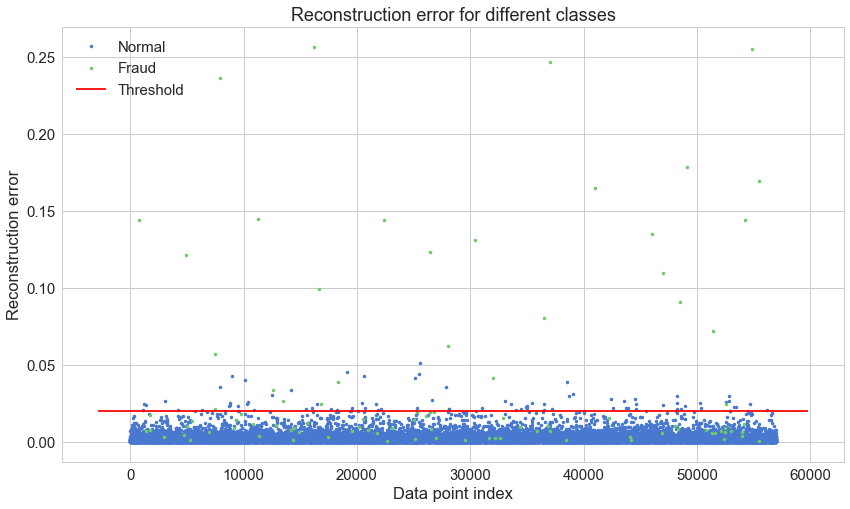

In [62]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, 
            group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Visualize the confusion matrix

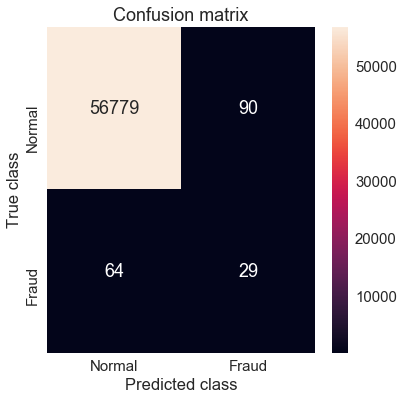

In [63]:
#for e in error_df.reconstruction_error.values:
#    if  e > threshold and 
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [64]:
print(conf_matrix)

[[56779    90]
 [   64    29]]


Calculating the accuracy.

In [65]:
print('Overall accuracy = ', (conf_matrix[0][0] + conf_matrix[1][1])/(conf_matrix[0][0] + conf_matrix[1][1] 
                                                                    + conf_matrix[0][1] + conf_matrix[1][0]))

Overall accuracy =  0.997296443243


In [66]:
target_names = ['class 0', 'class 1']
print(classification_report(y_val, y_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00     56869
    class 1       0.24      0.31      0.27        93

avg / total       1.00      1.00      1.00     56962

